## HITRAN data access for CH4 absorption coefficient at a given wavelength

target wavelength 2 [2.2 2.3]


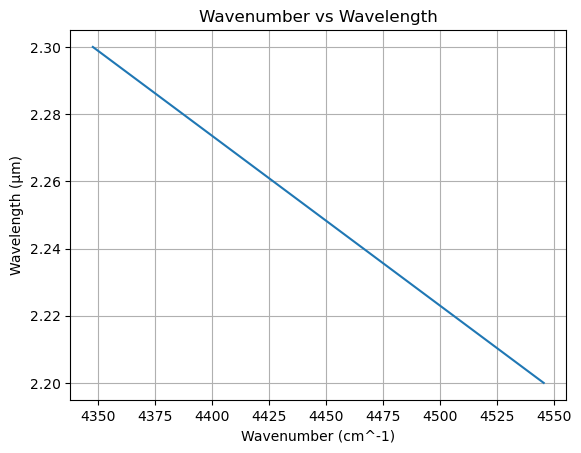

Using /Users/yunhalee/Documents/methanDart/Gaussian_CH4_Modeling/input_data/hitran

CH4
                     Lines parsed: 24625
CH4_sentinel2_11
                     Lines parsed: 5831
CH4_sentinel2_10
                     Lines parsed: 4954
CH4_sentinel2_12
                     Lines parsed: 24625

Data is fetched from http://hitran.org

BEGIN DOWNLOAD: CH4
  65536 bytes written to /Users/yunhalee/Documents/methanDart/Gaussian_CH4_Modeling/input_data/hitran/CH4.data
  65536 bytes written to /Users/yunhalee/Documents/methanDart/Gaussian_CH4_Modeling/input_data/hitran/CH4.data
  65536 bytes written to /Users/yunhalee/Documents/methanDart/Gaussian_CH4_Modeling/input_data/hitran/CH4.data
  65536 bytes written to /Users/yunhalee/Documents/methanDart/Gaussian_CH4_Modeling/input_data/hitran/CH4.data
  65536 bytes written to /Users/yunhalee/Documents/methanDart/Gaussian_CH4_Modeling/input_data/hitran/CH4.data
  65536 bytes written to /Users/yunhalee/Documents/methanDart/Gaussian_CH4_Modeling

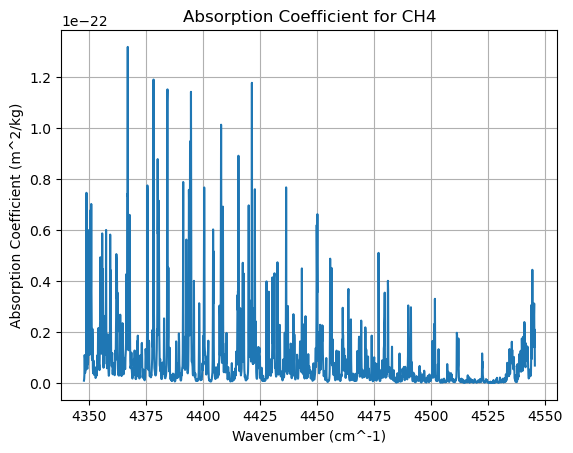

In [2]:
from hapi import *
import ssl
import os
import urllib.request
import numpy as np
import matplotlib.pyplot as plt


# Set necessary for accessing HITRAN database 
os.environ['GLOBAL_HOST'] = 'http://hitran.org'
ssl._create_default_https_context = ssl._create_unverified_context

# Set wavelength range and spectral resolution (you can match it with satellite)
# For Sentinel-2, the most useful band is 2.3 um. 
wavelength_limits = [2.2, 2.4] # micro meters
spectral_resolution = 0.1 # micro meters

#Compute wavelength range and wavenumber in cm^-1
target_wavelength = np.arange(wavelength_limits[0], wavelength_limits[1], spectral_resolution)
wavenumbers = 1.e4 / target_wavelength

print("target wavelength", len(target_wavelength), target_wavelength)

# Plotting the relationship between wavelength and wavenumber
plt.plot(wavenumbers, target_wavelength)
plt.xlabel('Wavenumber (cm^-1)')
plt.ylabel('Wavelength (µm)')
plt.title('Wavenumber vs Wavelength')
plt.grid(True)
plt.show()

# Set the local folder to download the HITRAN data
db_begin('/Users/yunhalee/Documents/methanDart/Gaussian_CH4_Modeling/input_data/hitran')
fetch('CH4',6,1,wavenumbers[1],wavenumbers[0])
describeTable('CH4')

# HITRAN_units : cm^2/molec (if True) and cm-1 (if False) and  WavenumberStep default value is 0.01 cm-1 but changed to 1 for now
nu,abs_coef = absorptionCoefficient_Lorentz(SourceTables='CH4', Diluent={'air':1.0}, HITRAN_units=True, Environment ={'T':296.,'p':1.}, WavenumberStep = 0.1)

print(len(abs_coef), len(target_wavelength))

# convert cm^2/mole to m2/kg, which is the concentration unit from the Gaussian Model. 
ch4_molar_weight = 0.01604 # kg/mole 
convert_unit = 1/ch4_molar_weight/1e4 # cm2/mole to m2/kg
abs_coef= abs_coef*convert_unit

# Plot the absorption coefficient
plt.plot(nu, abs_coef)
plt.xlabel('Wavenumber (cm^-1)')
plt.ylabel('Absorption Coefficient (m^2/kg)')
plt.title('Absorption Coefficient for CH4')
plt.grid(True)
plt.show()


In [3]:
# Numerical integration over the wavenumber using the trapezoidal rule
absorption_integrated = np.trapz(abs_coef, nu, axis=-1)

print("total absorption ", np.sum(abs_coef), absorption_integrated)

total absorption  1.7233474801623597e-20 1.722951874000959e-21


In [4]:
# Numerical integration over the wavenumber using the trapezoidal rule
absorption_integrated = np.trapz(abs_coef, axis=-1)

print("total absorption ", np.sum(abs_coef), absorption_integrated)

total absorption  1.7233474801623597e-20 1.722951874000836e-20


# Compute total extinction and transmittance with the GPM output

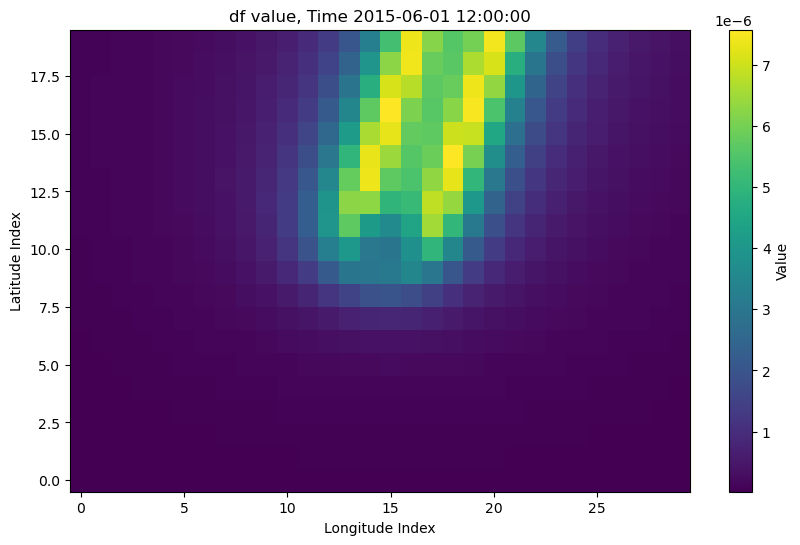

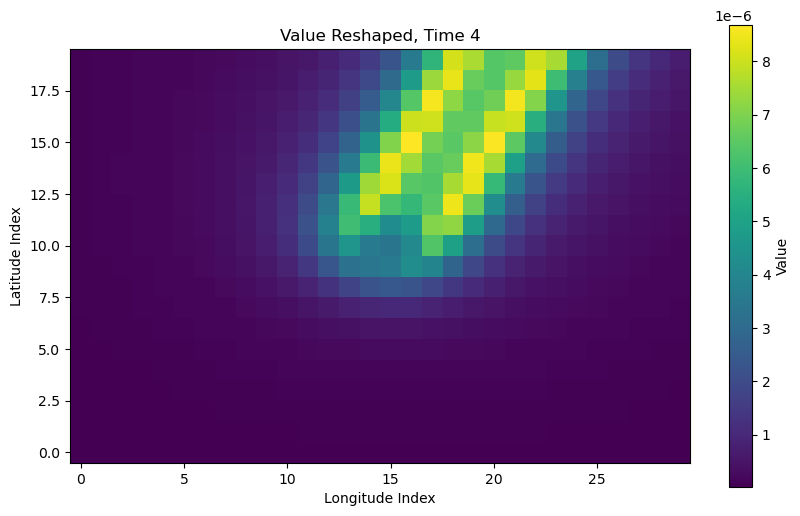

extinction per layer  (20, 30, 10, 6, 1977)
total_extinction  (20, 30, 6, 1977)
final_data  (20, 30, 6)


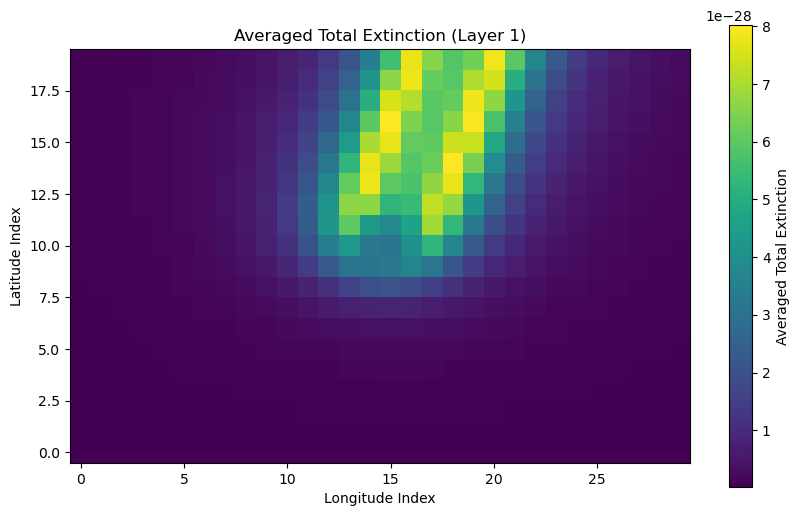

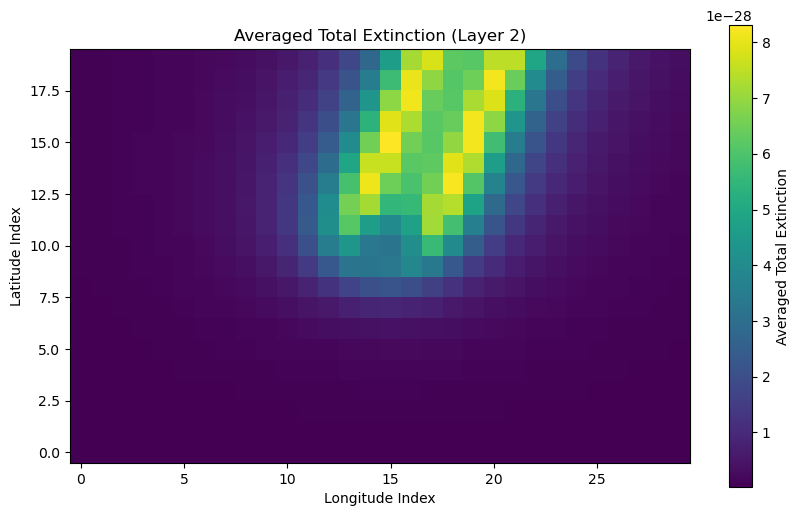

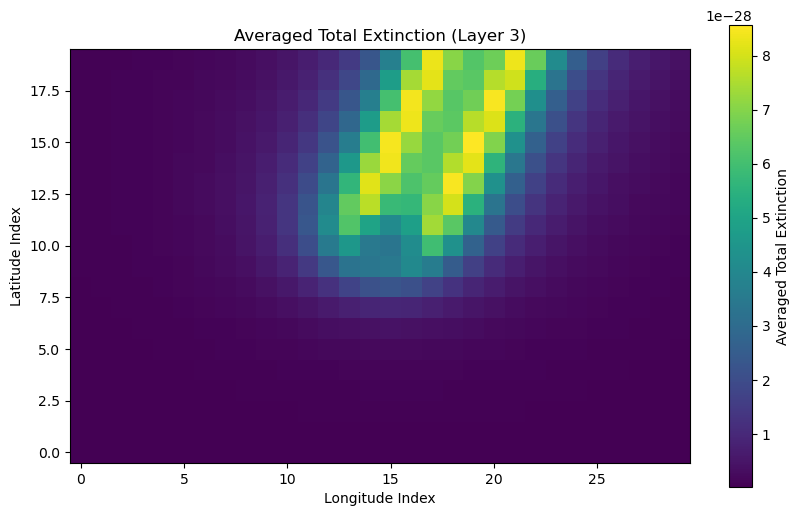

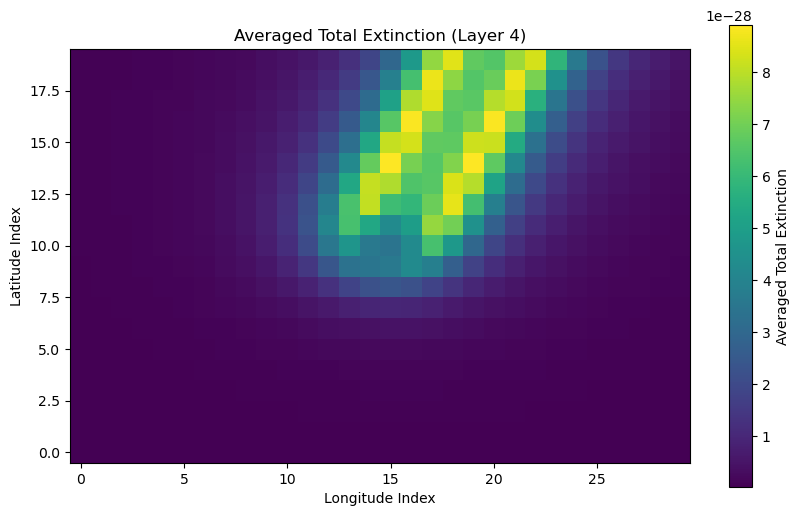

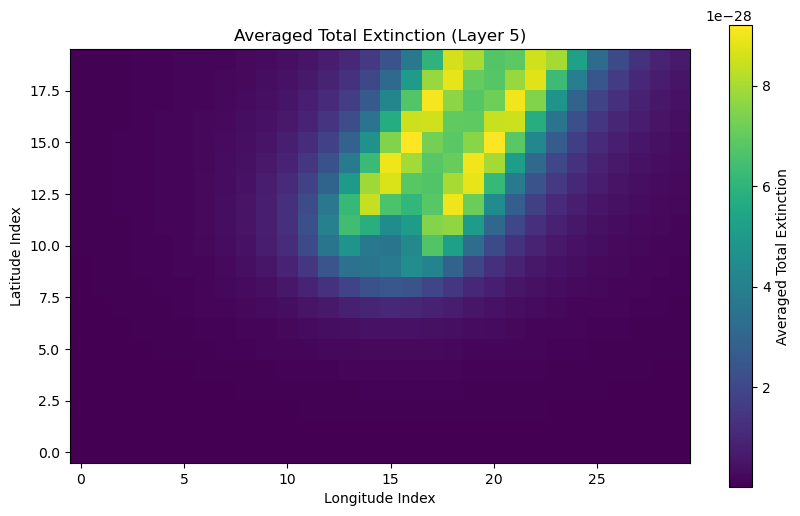

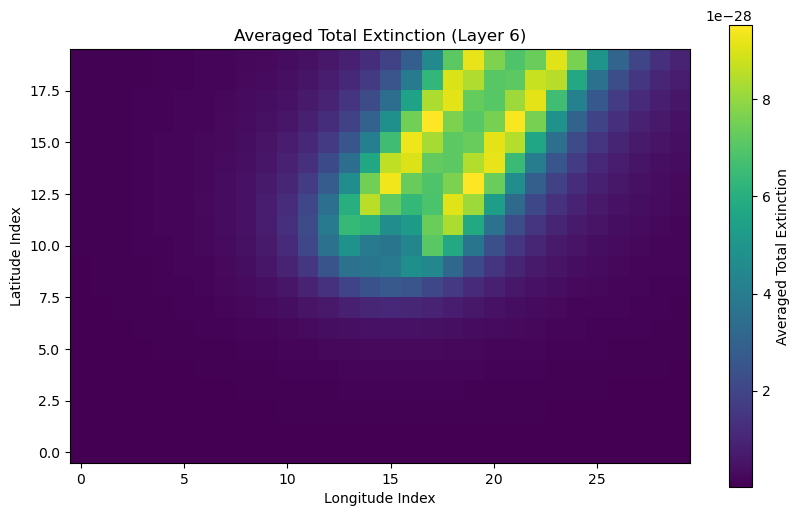

In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Get model output 
output_dir = "/Users/yunhalee/Documents/methanDart/Gaussian_Puff_CH4/output_data/"
output_dt_sec = 600
output_filename = f'{output_dir}simulation_output_resampled_at_{output_dt_sec}sec.csv'

df = pd.read_csv(output_filename)

# convert concentration from ppm to kg/m3
conversion_factor = 1e6 * 1.524
df['Value'] = df['Value']/conversion_factor
 
# Calculate mean values
df_sum = df.groupby(['times', 'lat', 'lon'])['Value'].sum().reset_index()

# Plot a slice at a specific time index, e.g., time index 0
time_index = 4
# Get the corresponding time value at the specified index
time_value = df_sum['times'].iloc[time_index]

# Filter df_sum for the selected time value
df_time_slice = df_sum[df_sum['times'] == time_value]

# Pivot the data to create a 2D grid for plotting
df_pivot = df_time_slice.pivot(index='lat', columns='lon', values='Value')

# Plot the slice
plt.figure(figsize=(10, 6))
plt.imshow(df_pivot, cmap='viridis', origin='lower', aspect='auto')
plt.colorbar(label='Value')
plt.title(f'df value, Time {time_value}')
plt.xlabel('Longitude Index')
plt.ylabel('Latitude Index')
plt.show()

# Get unique values for the grid
lat_vals = df['lat'].unique()
lon_vals = df['lon'].unique()
height_vals = df['height'].unique()
time_vals = df['times'].unique()

# Create 4D arrays to hold the reshaped values
value_reshaped = np.empty((len(lat_vals), len(lon_vals), len(height_vals), len(time_vals)))  # Note: lat is now the first dimension
height_reshaped = np.empty((len(lat_vals), len(lon_vals), len(height_vals), len(time_vals)))

# Populate the 4D arrays
for i, time in enumerate(time_vals):
    for j, lat in enumerate(lat_vals):  # lat index first
        for k, lon in enumerate(lon_vals):  # lon index second
            for l, height in enumerate(height_vals):
                # Extract the value from the dataframe for the specific indices
                mask = (
                    (df['times'] == time) &
                    (df['lat'] == lat) &
                    (df['lon'] == lon) &
                    (df['height'] == height)
                )
                # Check if there's a value matching this combination
                if not df[mask].empty:
                    value_reshaped[j, k, l, i] = df[mask]['Value'].values[0]
                    height_reshaped[j, k, l, i] = df[mask]['height'].values[0]
                else:
                    raise ValueError("Value must be available for reshaping.")



time_index = 4
plt.figure(figsize=(10, 6))
plt.imshow(np.sum(value_reshaped, axis =2)[:, :, time_index], cmap='viridis', origin='lower')
plt.colorbar(label='Value')
plt.title(f'Value Reshaped, Time {time_index}')
plt.xlabel('Longitude Index')
plt.ylabel('Latitude Index')
plt.show()

# Reshape the arrays to be 5D dimensions to compute extinction
value_reshaped = value_reshaped[:, :, :, :, np.newaxis]  # (lon, lat, height, time, 1)
height_reshaped = height_reshaped[:, :, :, :, np.newaxis]  # (lon, lat, height, time, 1)
wavenumber_dim = len(abs_coef)
abs_coef_reshaped = abs_coef.reshape(1, 1, 1, 1, wavenumber_dim)
extinction_per_layer = value_reshaped * height_reshaped * abs_coef_reshaped
print("extinction per layer ", extinction_per_layer.shape)

# Summing over height
total_extinction = np.sum(extinction_per_layer, axis=2)  
print("total_extinction ", total_extinction.shape)

# Average over the last dimension, wavenumbers
final_data = np.mean(total_extinction, axis=-1)  # Resulting shape will be (lon, lat, times)
print("final_data ", final_data.shape)

# Plotting the final data
for i in range(final_data.shape[2]):
    plt.figure(figsize=(10, 6))
    plt.imshow(final_data[:, :, i], cmap='viridis', origin='lower')
    plt.colorbar(label='Averaged Total Extinction')
    plt.title(f'Averaged Total Extinction (Layer {i+1})')
    plt.xlabel('Longitude Index')
    plt.ylabel('Latitude Index')
    plt.show()


# Calculate total transmittance based on Beer-Lambert Law
final_transmittance = np.exp(-final_data)
print("total_transmittance ", final_transmittance.shape)

# Plotting the final transmittance data
for i in range(final_transmittance.shape[2]):
    plt.figure(figsize=(10, 6))
    plt.imshow(final_transmittance[:, :, i], cmap='viridis', origin='lower', vmin =0.9, vmax = 1)
    plt.colorbar(label='Total Transmittance')
    plt.title(f'Total Transmittance (Time Step {i+1})')
    plt.xlabel('Longitude Index')
    plt.ylabel('Latitude Index')
    plt.show()

total_transmittance  (20, 30, 6)


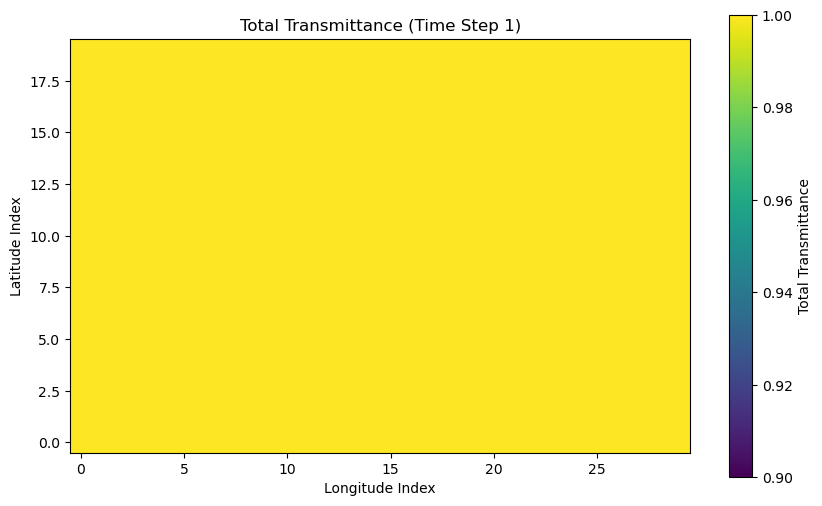

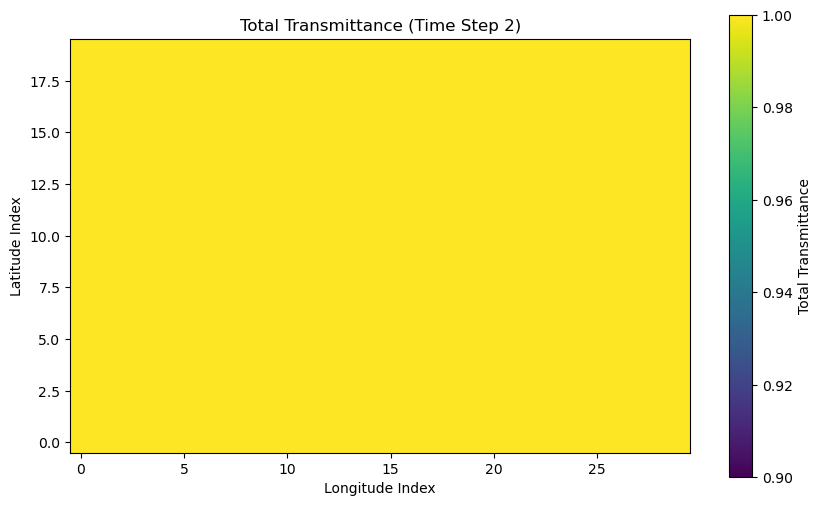

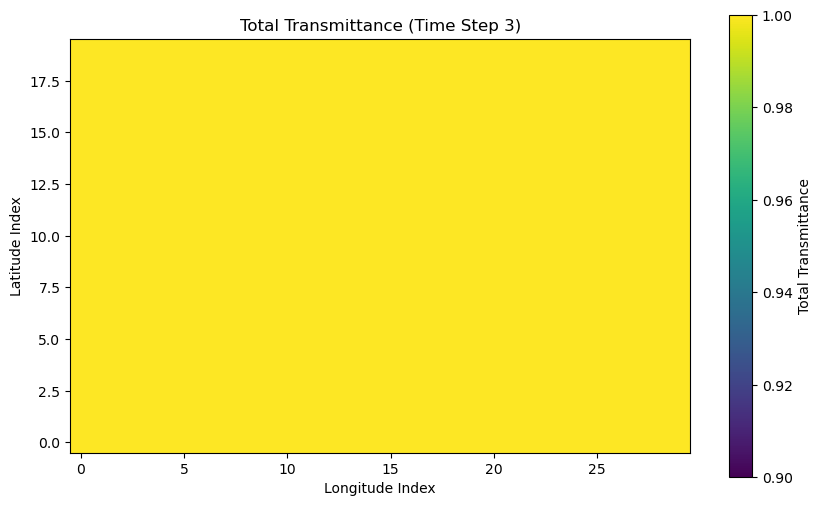

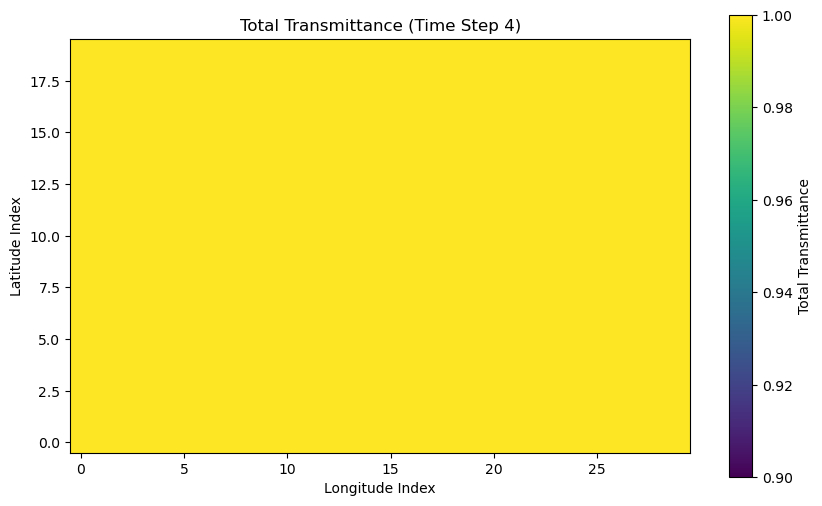

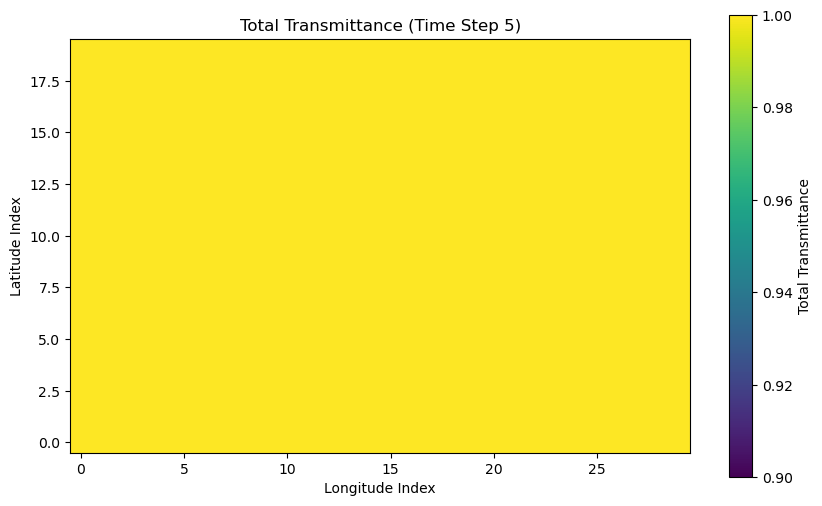

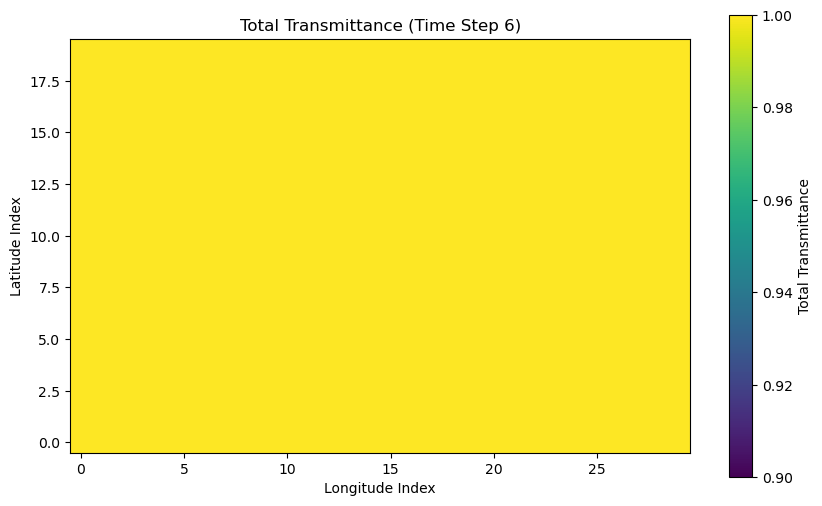